## Session3. Combining samples and Quality Control  

scATAC-seq analysis is primarily based on peaks—regions of accessible chromatin identified across cells. Each cell is represented as a vector of peak accessibility, forming a sparse matrix that is the foundation for all downstream analyses.

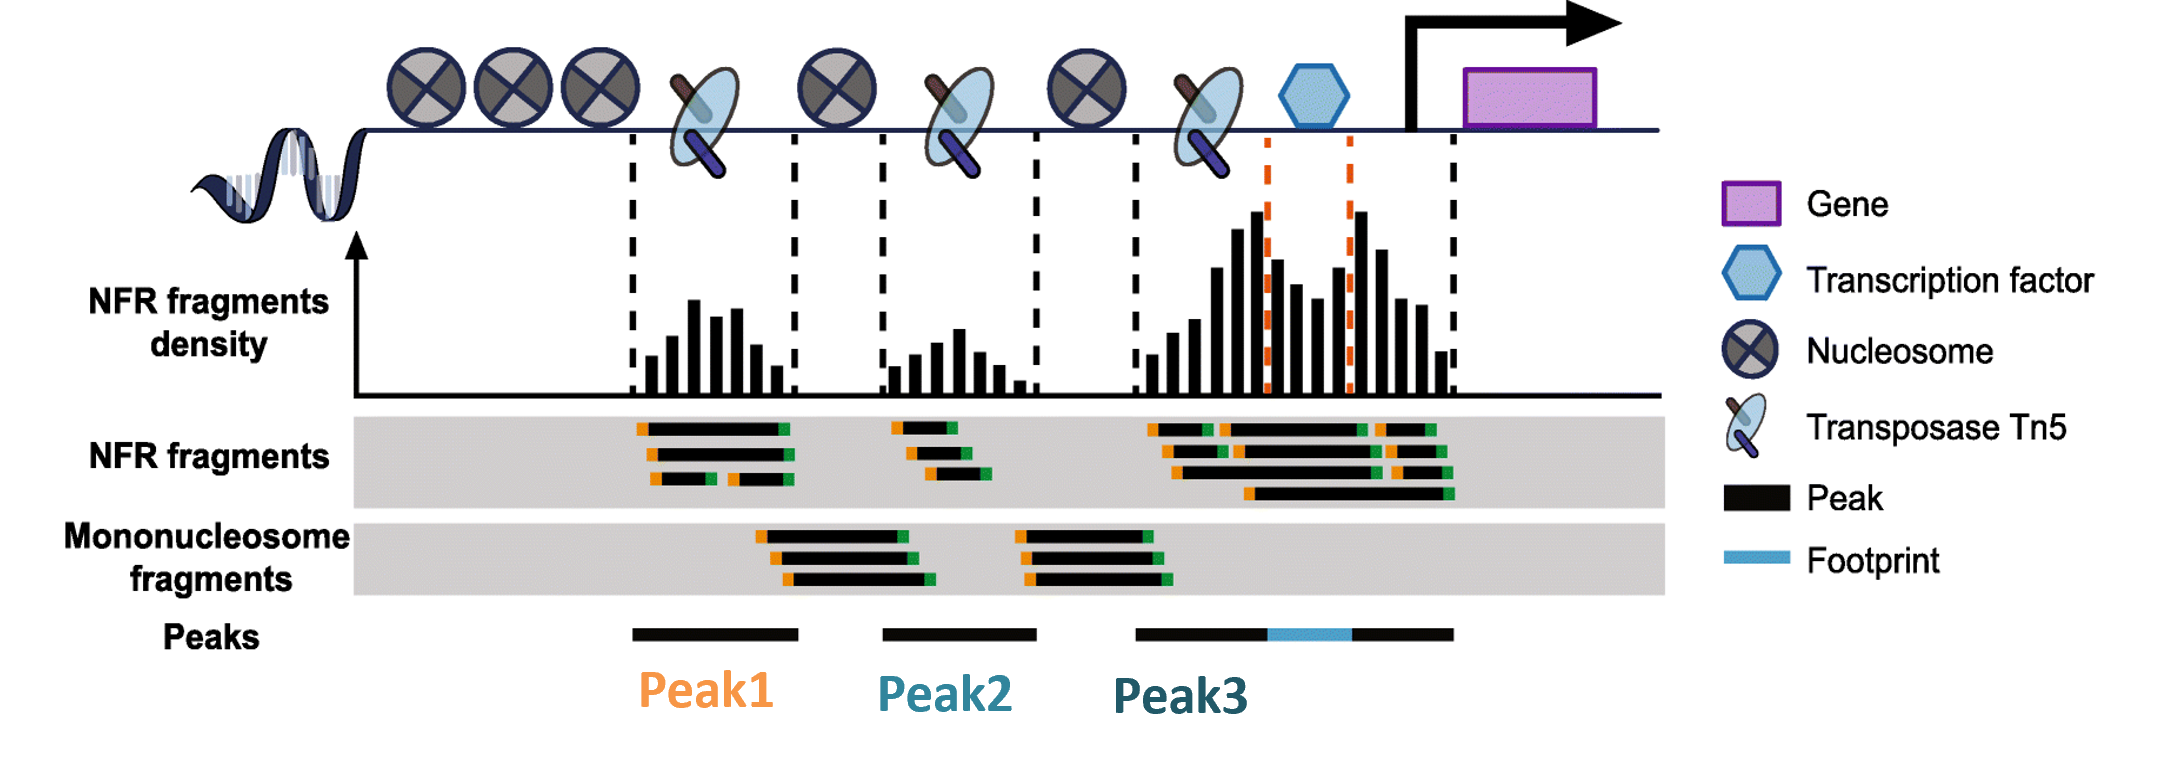

#### Setup
First, ensure that the necessary R packages are installed and loaded.

In [1]:
# Install required packages if not already installed
if (!requireNamespace("Signac", quietly = TRUE)) {
  install.packages("Signac")
}
if (!requireNamespace("Seurat", quietly = TRUE)) {
  install.packages("Seurat")
}

if (!requireNamespace("ggplot2", quietly = TRUE)) {
  install.packages("ggplot2")
}

if (!requireNamespace("BiocManager", quietly = TRUE)) {
  install.packages("BiocManager")
}

if (!requireNamespace("GenomicRanges", quietly = TRUE)) {
BiocManager::install("GenomicRanges")
}


if (!requireNamespace("SingleCellExperiment", quietly = TRUE)) {
BiocManager::install("SingleCellExperiment")
}

if (!requireNamespace("scDblFinder", quietly = TRUE)) {
BiocManager::install("scDblFinder")
}

if (!requireNamespace("rtracklayer", quietly = TRUE)) {
BiocManager::install("rtracklayer")
}

if (!requireNamespace("aggregation", quietly = TRUE)) {
  install.packages("aggregation")
}

# Load libraries
library(Signac)
library(Seurat)
library(GenomicRanges)
library(ggplot2)

library(SingleCellExperiment)
library(scDblFinder)
library(rtracklayer)
library(aggregation)


Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t


Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following object is masked from ‘package:SeuratObject’:

    intersect


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, saveRDS, setdiff,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The following 

##### Download the input files listed below from Google Drive

- pbmc_unsorted_10k_atac_peaks.bed
- pbmc_unsorted_10k_per_barcode_metrics.csv
- pbmc_unsorted_10k_atac_fragments.tsv.gz
- pbmc_unsorted_10k_atac_fragments.tsv.gz.tbi
<br>

- 10k_PBMC_Multiome_nextgem_Chromium_Controller_atac_peaks.bed
- 10k_PBMC_Multiome_nextgem_Chromium_Controller_per_barcode_metrics.csv
- 10k_PBMC_Multiome_nextgem_Chromium_Controller_atac_fragments.tsv.gz
- 10k_PBMC_Multiome_nextgem_Chromium_Controller_atac_fragments.tsv.gz.tbi
<br> 

- PMBC.ATAC.sample1_res_amulet.rds
- PMBC.ATAC.sample2_res_amulet.rds


### Step1.  Merging Single-Cell Chromatin Data with Signac  





In single-cell chromatin accessibility studies, it's common to have multiple datasets that need to be combined for integrated analysis. However, if peak calling was performed independently on each dataset, the resulting peak sets may differ, complicating the merging process. This session demonstrates how to create a common set of peaks and merge multiple Seurat objects using Signac.

### Step1-1. Create a unified peak set

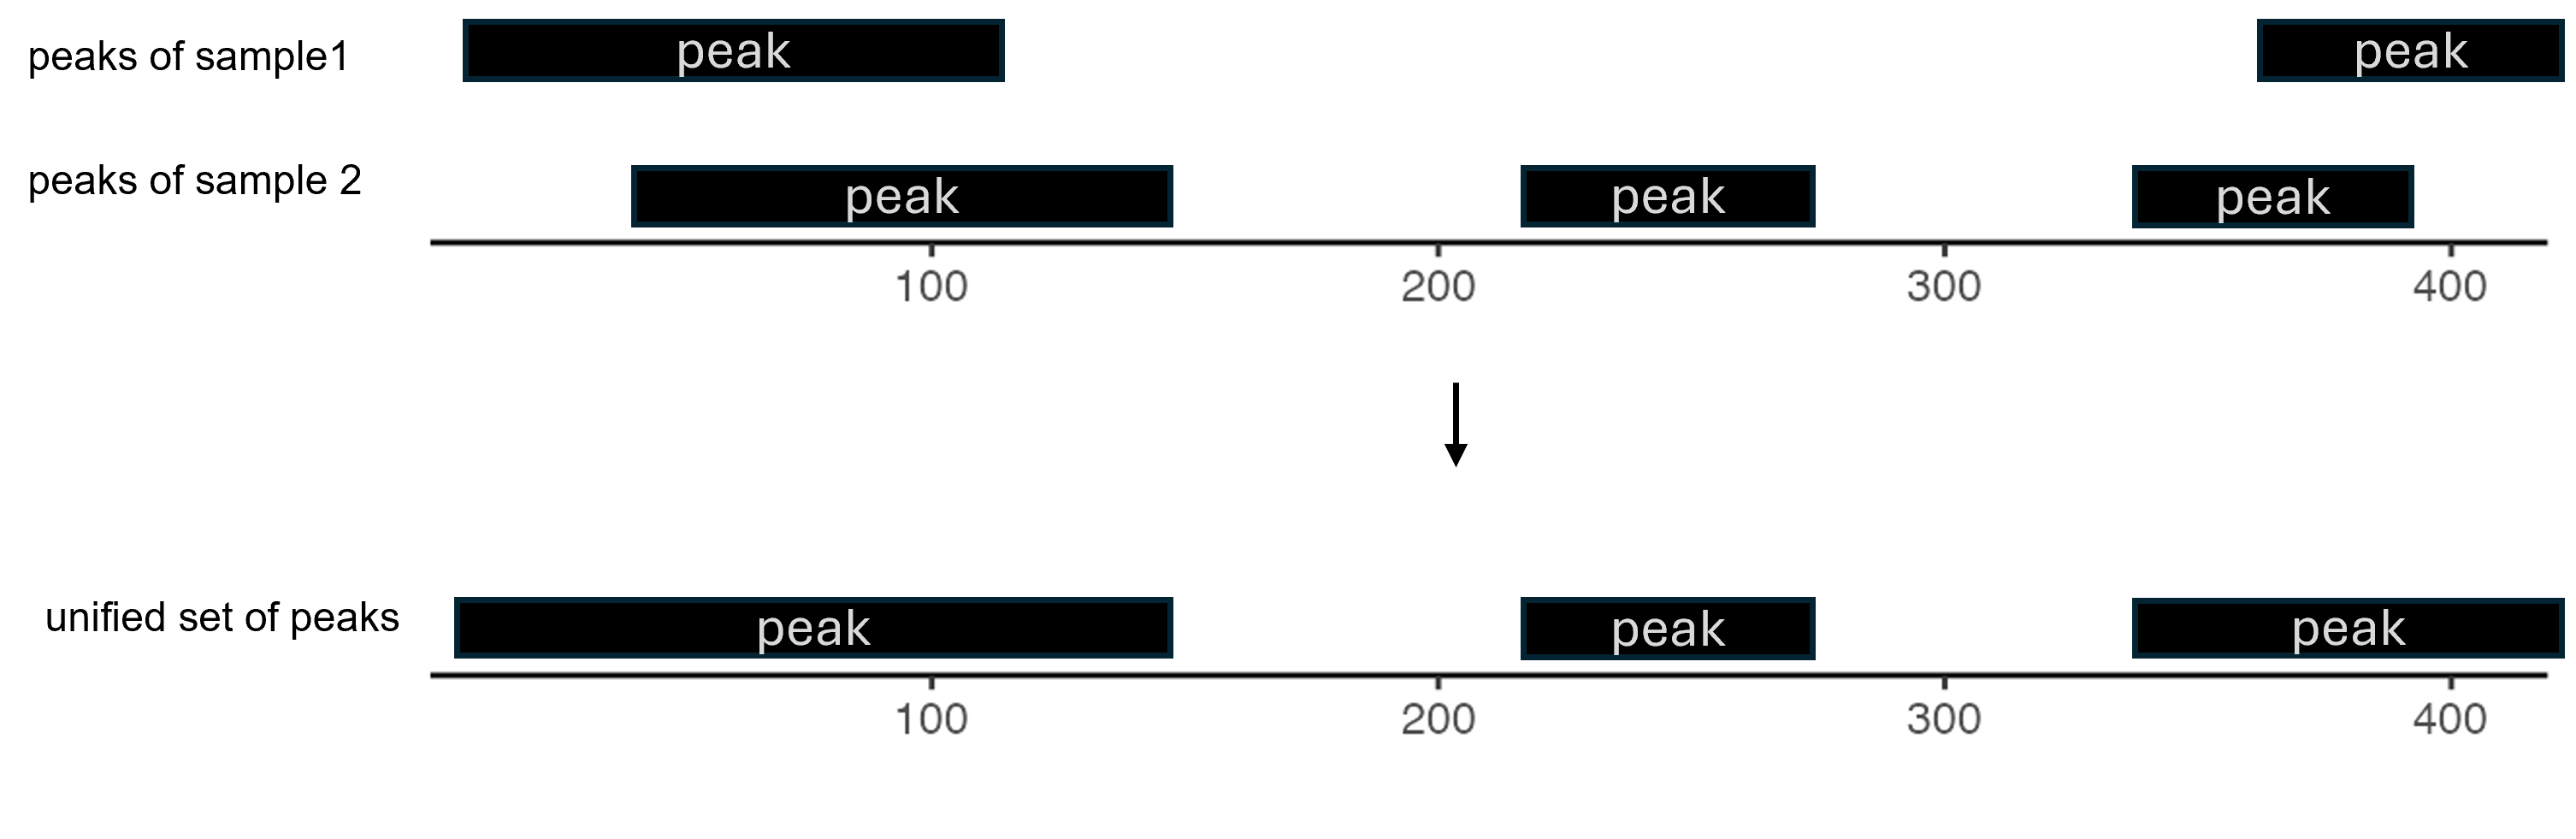

##### Loading Peak Sets
Read the peak files and convert them into GRanges objects

In [2]:
sample1.peak = read.table('pbmc_unsorted_10k_atac_peaks.bed', 
                          col.names=c('chr','start','end'))

sample2.peak = read.table('10k_PBMC_Multiome_nextgem_Chromium_Controller_atac_peaks.bed', 
          col.names=c('chr','start','end') )

In [3]:
head(sample1.peak)

,chr,start,end
,<chr>,<int>,<int>
1,chr1,9790,10676
2,chr1,180654,181318
3,chr1,191155,192066
4,chr1,267573,268458
5,chr1,270881,271760
6,chr1,585751,586643


In [4]:
head(sample2.peak)

,chr,start,end
,<chr>,<int>,<int>
1,chr1,9772,10662
2,chr1,180652,181258
3,chr1,181327,181650
4,chr1,191158,192087
5,chr1,267570,268453
6,chr1,585749,586643


In [5]:
# convert to genomic ranges
gr.sample1 <- makeGRangesFromDataFrame(sample1.peak)
gr.sample2 <- makeGRangesFromDataFrame(sample2.peak)

In [6]:
gr.sample1

GRanges object with 111857 ranges and 0 metadata columns:
             seqnames        ranges strand
                <Rle>     <IRanges>  <Rle>
       [1]       chr1    9790-10676      *
       [2]       chr1 180654-181318      *
       [3]       chr1 191155-192066      *
       [4]       chr1 267573-268458      *
       [5]       chr1 270881-271760      *
       ...        ...           ...    ...
  [111853] KI270713.1   21448-22354      *
  [111854] KI270713.1   26124-26873      *
  [111855] KI270713.1   29681-30482      *
  [111856] KI270713.1   34378-35108      *
  [111857] KI270713.1   36924-37836      *
  -------
  seqinfo: 36 sequences from an unspecified genome; no seqlengths

##### Creating a Unified Peak Set
Merge the individual peak sets to create a common set of peaks across all datasets:

In [7]:
# Create a unified set of peaks to quantify in each dataset
combined.peaks <- reduce(x = c(gr.sample1, gr.sample2))

In [8]:
# Filter out bad peaks based on length
peakwidths <- width(combined.peaks)
combined.peaks <- combined.peaks[peakwidths  < 10000 & peakwidths > 20]
combined.peaks

GRanges object with 130464 ranges and 0 metadata columns:
             seqnames          ranges strand
                <Rle>       <IRanges>  <Rle>
       [1]       chr1      9772-10676      *
       [2]       chr1   180652-181318      *
       [3]       chr1   181327-181650      *
       [4]       chr1   191155-192087      *
       [5]       chr1   267570-268458      *
       ...        ...             ...    ...
  [130460] KI270728.1 1791274-1791981      *
  [130461] KI270728.1 1792095-1792584      *
  [130462] KI270734.1   121018-121934      *
  [130463] KI270734.1   130514-131383      *
  [130464] KI270734.1   133494-134374      *
  -------
  seqinfo: 36 sequences from an unspecified genome; no seqlengths

### Step1-2. make a peak count matrix based on new unified peak set

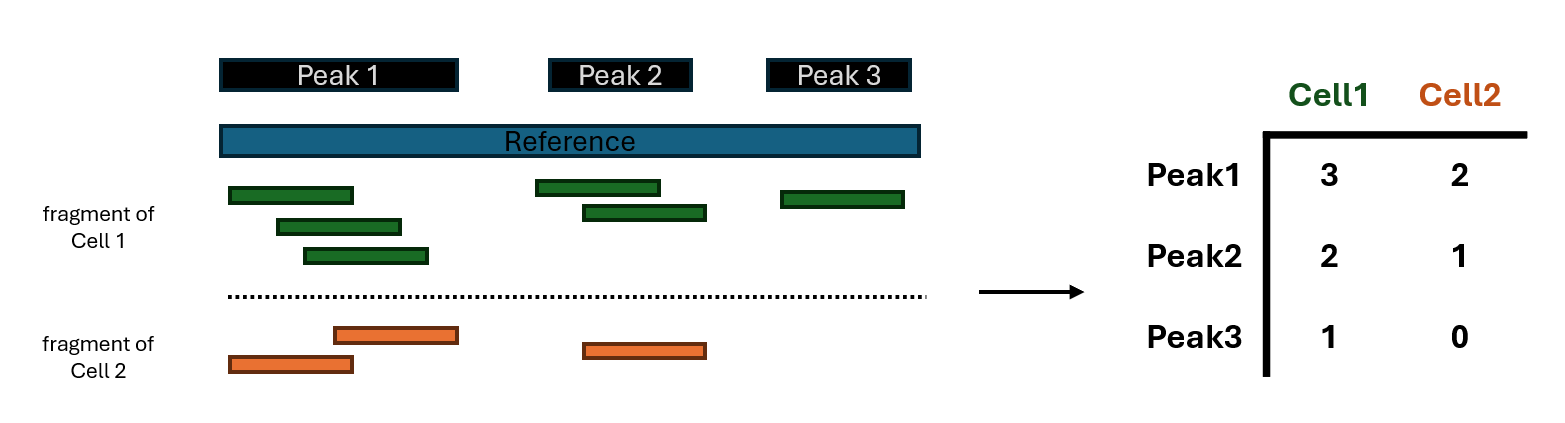

##### Create Fragment objects
To quantify the combined set of peaks, we need to generate a Fragment object for each experiment. In Signac, the Fragment class is specifically designed to store all the information associated with a single fragment file.

In [9]:
md.sample1 = read.table('pbmc_unsorted_10k_per_barcode_metrics.csv',
                           sep=',',
                           stringsAsFactors = FALSE,
                           header = TRUE,
                           row.names = 1
                       )[-1,]# remove the first row

md.sample2 = read.table('10k_PBMC_Multiome_nextgem_Chromium_Controller_per_barcode_metrics.csv',
                           sep=',',
                           stringsAsFactors = FALSE,
                           header = TRUE,
                           row.names = 1
                       )[-1,]# remove the first row


In [10]:
head(md.sample1)

,gex_barcode,atac_barcode,is_cell,excluded_reason,gex_raw_reads,gex_mapped_reads,gex_conf_intergenic_reads,gex_conf_exonic_reads,gex_conf_intronic_reads,gex_conf_exonic_unique_reads,⋯,atac_raw_reads,atac_unmapped_reads,atac_lowmapq,atac_dup_reads,atac_chimeric_reads,atac_mitochondrial_reads,atac_fragments,atac_TSS_fragments,atac_peak_region_fragments,atac_peak_region_cutsites
,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
AAACAGCCAAACATAG-1,AAACAGCCAAACATAG-1,ACAGCGGGTTGTTCTT-1,0,2,22,22,0,0,22,0,⋯,6,0,1,1,0,1,3,1,0,0
AAACAGCCAAACCCTA-1,AAACAGCCAAACCCTA-1,ACAGCGGGTAACAGGC-1,0,0,32,29,0,9,18,9,⋯,38,24,6,0,0,2,6,2,1,2
AAACAGCCAAACCTAT-1,AAACAGCCAAACCTAT-1,ACAGCGGGTGCGCGAA-1,0,0,5,5,3,1,1,0,⋯,2,1,0,0,0,0,1,1,1,1
AAACAGCCAAACCTTG-1,AAACAGCCAAACCTTG-1,ACAGCGGGTCCTCCAT-1,0,0,71,70,9,17,32,15,⋯,6,1,0,2,0,0,3,1,3,6
AAACAGCCAAACGCGA-1,AAACAGCCAAACGCGA-1,ACAGCGGGTCATGGTT-1,0,0,3,2,0,0,2,0,⋯,5,1,0,0,0,0,4,1,1,1
AAACAGCCAAACGGGC-1,AAACAGCCAAACGGGC-1,ACAGCGGGTAGGTGAC-1,0,0,27,24,0,21,3,21,⋯,5,1,1,0,0,0,3,2,2,4


In [11]:
# Extract the initially QC-filtered cells,
md.sample1  <- md.sample1[md.sample1$is_cell==1, ]
md.sample2  <- md.sample2[md.sample2$is_cell==1, ]


In [12]:
# Create Fragment objects
frags.sample1 <- CreateFragmentObject(
  path = "pbmc_unsorted_10k_atac_fragments.tsv.gz",
  cells = rownames(md.sample1)
)

frags.sample2 <- CreateFragmentObject(
  path = "10k_PBMC_Multiome_nextgem_Chromium_Controller_atac_fragments.tsv.gz",
  cells = rownames(md.sample2)
)

Computing hash

Computing hash



In [13]:
frags.sample1

A Fragment object for 12012 cells

##### Quantify peaks in each dataset
Next, we can generate a peaks x cell matrix for each sample using the FeatureMatrix function. This function utilizes parallel processing through the future package, which can accelerate computation. However, it is important to configure the parallelization parameters carefully to prevent resource overuse that could cause probelm.

In [14]:
# Quantify peaks in each dataset
sample1.counts <- FeatureMatrix(
  fragments = frags.sample1,
  features = combined.peaks,
  cells = rownames(md.sample1)
)

sample2.counts <- FeatureMatrix(
  fragments = frags.sample2,
  features = combined.peaks,
  cells = rownames(md.sample2)
)

Extracting reads overlapping genomic regions

Extracting reads overlapping genomic regions



In [15]:
sample1.counts[1:5,1:5]

5 x 5 sparse Matrix of class "dgCMatrix"
                   AAACAGCCAAAGCCTC-1 AAACAGCCAGAATGAC-1 AAACAGCCAGCTACGT-1
chr1-9772-10676                     .                  .                  .
chr1-180652-181318                  .                  .                  .
chr1-181327-181650                  .                  .                  .
chr1-191155-192087                  .                  .                  .
chr1-267570-268458                  .                  .                  .
                   AAACAGCCAGGCCTTG-1 AAACAGCCATAAGGAC-1
chr1-9772-10676                     .                  .
chr1-180652-181318                  .                  .
chr1-181327-181650                  .                  .
chr1-191155-192087                  .                  .
chr1-267570-268458                  .                  .

##### Construct a Signac object individually for each dataset
We will now use the quantified matrices to create a Seurat object for each dataset, embedding the corresponding Fragment object within the assay of each Seurat object.

In [16]:
sample1_assay <- CreateChromatinAssay(sample1.counts, fragments = frags.sample1)
sample1 <- CreateSeuratObject(sample1_assay, assay = "ATAC",meta.data=md.sample1)

sample2_assay <- CreateChromatinAssay(sample2.counts, fragments = frags.sample2)
sample2 <- CreateSeuratObject(sample2_assay, assay = "ATAC",meta.data=md.sample2)


In [17]:
sample1

An object of class Seurat 
130464 features across 12012 samples within 1 assay 
Active assay: ATAC (130464 features, 0 variable features)
 2 layers present: counts, data

In [18]:
sample2

An object of class Seurat 
130464 features across 10691 samples within 1 assay 
Active assay: ATAC (130464 features, 0 variable features)
 2 layers present: counts, data

##### Merge individual Signac objects into a single combined object
Since each object now contains an assay with a consistent set of features, we can utilize the merge function to combine them. This process also consolidates all the Fragment objects, preserving the fragment information for each cell within the final merged object.


In [23]:
# add information to identify dataset of origin
sample1$dataset <- 'sample1'
sample2$dataset <- 'sample2'

# merge all datasets, adding a cell ID to make sure cell names are unique
data <- merge(
  x = sample1,
  y = list(sample2),
  add.cell.ids = c("sample1","sample2")
)

In [24]:
data

An object of class Seurat 
130464 features across 22703 samples within 1 assay 
Active assay: ATAC (130464 features, 0 variable features)
 2 layers present: counts, data

In [25]:
saveRDS(data,'PBMC.before_qc.rds')

### Step2.  Data Quality Control




Quality Control (QC) metrics are crucial in scATAC-seq experiments to filter out low-quality cells and technical artifacts, ensuring reliable downstream analysis. 

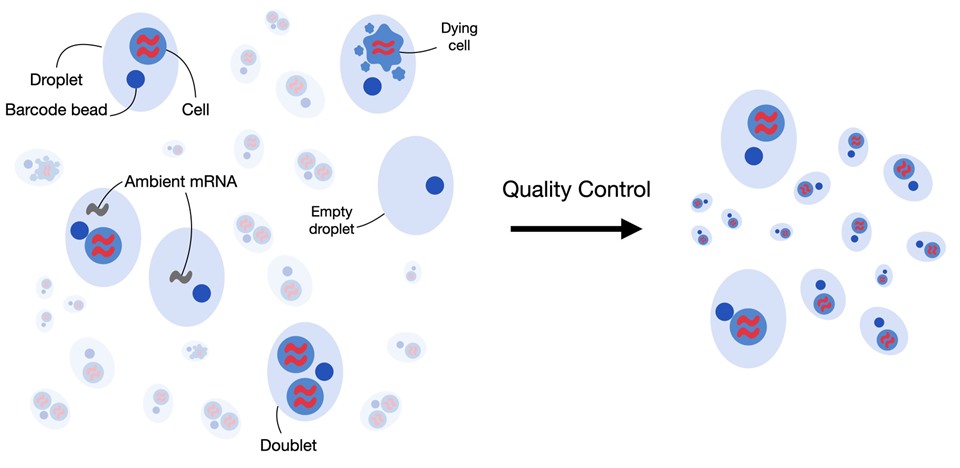

### Step2-1. basic processing

##### Removing Non-Standard Chromosomes
The first step in our workflow is to remove features (peaks) that are mapped to non-standard chromosomes like scaffolds (e.g., KI270713.1). These scaffolds are usually temporary assemblies and are not part of the standard 22 autosomes + 2 sex chromosomes.

In [26]:
data

An object of class Seurat 
130464 features across 22703 samples within 1 assay 
Active assay: ATAC (130464 features, 0 variable features)
 2 layers present: counts, data

In [27]:
data.keep <- seqnames(granges(data)) %in% standardChromosomes(granges(data))
data <- data[as.vector(data.keep), ]

In [28]:
data

An object of class Seurat 
130381 features across 22703 samples within 1 assay 
Active assay: ATAC (130381 features, 0 variable features)
 2 layers present: counts, data

##### Adding Gene Annotations
Next, we will add gene annotations to our Seurat object. This allows us to leverage gene-level information during downstream analysis, such as peak-to-gene linkage and gene activity analysis.

- We use EnsDb.Hsapiens.v98 which corresponds to GRCh38-2020-A, the same reference used for 10x Genomics mapping.

- Annotations are added directly to the Seurat object for downstream use.

In [29]:
library(AnnotationHub)
ah <- AnnotationHub()

# Search for the Ensembl 98 EnsDb for Homo sapiens on AnnotationHub
query(ah, "EnsDb.Hsapiens.v98")

Loading required package: BiocFileCache

Loading required package: dbplyr


Attaching package: ‘AnnotationHub’


The following object is masked from ‘package:rtracklayer’:

    hubUrl


The following object is masked from ‘package:Biobase’:

    cache




AnnotationHub with 1 record
# snapshotDate(): 2024-10-28
# names(): AH75011
# $dataprovider: Ensembl
# $species: Homo sapiens
# $rdataclass: EnsDb
# $rdatadateadded: 2019-05-02
# $title: Ensembl 98 EnsDb for Homo sapiens
# $description: Gene and protein annotations for Homo sapiens based on Ensem...
# $taxonomyid: 9606
# $genome: GRCh38
# $sourcetype: ensembl
# $sourceurl: http://www.ensembl.org
# $sourcesize: NA
# $tags: c("98", "AHEnsDbs", "Annotation", "EnsDb", "Ensembl", "Gene",
#   "Protein", "Transcript") 
# retrieve record with 'object[["AH75011"]]' 

In [30]:
ensdb_v98 <- ah[["AH75011"]]

loading from cache

require(“ensembldb”)



In [31]:
### extract gene annotations from EnsDb
annotations <- GetGRangesFromEnsDb(ensdb = ensdb_v98)

# change to UCSC style since the data was mapped to hg38
seqlevels(annotations) <- paste0('chr', seqlevels(annotations))
genome(annotations) <- "hg38"

Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warning message in .merge_two_Seqinfo_objects(x, y):
"The 2 combined objects have no sequence levels in common. (Use
  suppressWarnings() to suppress this warning.)"
Warn

In [32]:
# add the gene information to the object
Annotation(data) <- annotations

- We use EnsDb.Hsapiens.v98 which corresponds to GRCh38-2020-A, the same reference used for 10x Genomics mapping.

- seqlevelsStyle converts chromosome naming to UCSC format (chr1, chr2, etc.).

- Annotations are added directly to the Seurat object for downstream use.

### Step2-2. Compute Quality Control (QC) Metrics

##### Nucleosome Banding Pattern
- It measures the ratio of mononucleosomal fragments (around 147 bp, wrapped around a nucleosome) to nucleosome-free fragments (typically <100 bp).

- A high nucleosome signal indicates that most of the sequenced fragments come from nucleosome-bound regions, rather than open, accessible chromatin.

- In dying or apoptotic cells, chromatin becomes condensed, and ATAC-seq signal may become dominated by nucleosomal fragments.



In [33]:
# compute nucleosome signal score per cell
data <- NucleosomeSignal(object = data)


##### Transcriptional Start Site (TSS) Enrichment Score
- TSS enrichment score measures how well ATAC-seq signal is enriched at transcription start sites (TSSs).

- TSS enrichment measures the concentration of fragments at TSSs compared to flanking regions. 

- In high-quality scATAC-seq data, open chromatin is highly enriched around TSSs due to the presence of active promoters.

In [34]:
# compute TSS enrichment score per cell
data <- TSSEnrichment(object = data)


Extracting TSS positions

Extracting fragments at TSSs

Warning message in cc + as.vector(x = counts.center):
"longer object length is not a multiple of shorter object length"
Warning message in cc[names(x = counts.center)] <- cc + as.vector(x = counts.center):
"number of items to replace is not a multiple of replacement length"
Warning message in fc + as.vector(x = counts.flank):
"longer object length is not a multiple of shorter object length"
Warning message in fc[names(x = counts.flank)] <- fc + as.vector(x = counts.flank):
"number of items to replace is not a multiple of replacement length"
Warning message in cc + as.vector(x = counts.center):
"longer object length is not a multiple of shorter object length"
Warning message in cc[names(x = counts.center)] <- cc + as.vector(x = counts.center):
"number of items to replace is not a multiple of replacement length"
Warning message in fc + as.vector(x = counts.flank):
"longer object length is not a multiple of shorter object length"
War

##### Ratio of Reads in Genomic Blacklist Regions
- Blacklist regions: Certain genomic regions, identified by ENCODE as blacklist regions, consistently show artifactual signals.

- High proportions of reads in these regions suggest technical artifacts.


In [35]:
# add blacklist ratio
data$blacklist_ratio <- FractionCountsInRegion(
  object = data, 
  regions = blacklist_hg38_unified
)

##### Total Number of Fragments in Peaks
- Represents the total number of sequencing reads that fall within called peak regions.

- Cells with very few reads may need to be excluded due to low sequencing depth.

- Cells with extremely high levels may represent doublets, nuclei clumps, or other artefacts.

- This metric was computed during the Cell Ranger preprocessing step.

### Step2-3. Check the distribution of each QC metric across cells

In [36]:
options(repr.plot.width = 8, repr.plot.height = 20)

Warning message:
"The `slot` argument of `FetchData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead.
ℹ The deprecated feature was likely used in the Seurat package.
  Please report the issue at <https://github.com/satijalab/seurat/issues>."
Warning message:
"`PackageCheck()` was deprecated in SeuratObject 5.0.0.
ℹ Please use `rlang::check_installed()` instead.
ℹ The deprecated feature was likely used in the Seurat package.
  Please report the issue at <https://github.com/satijalab/seurat/issues>."


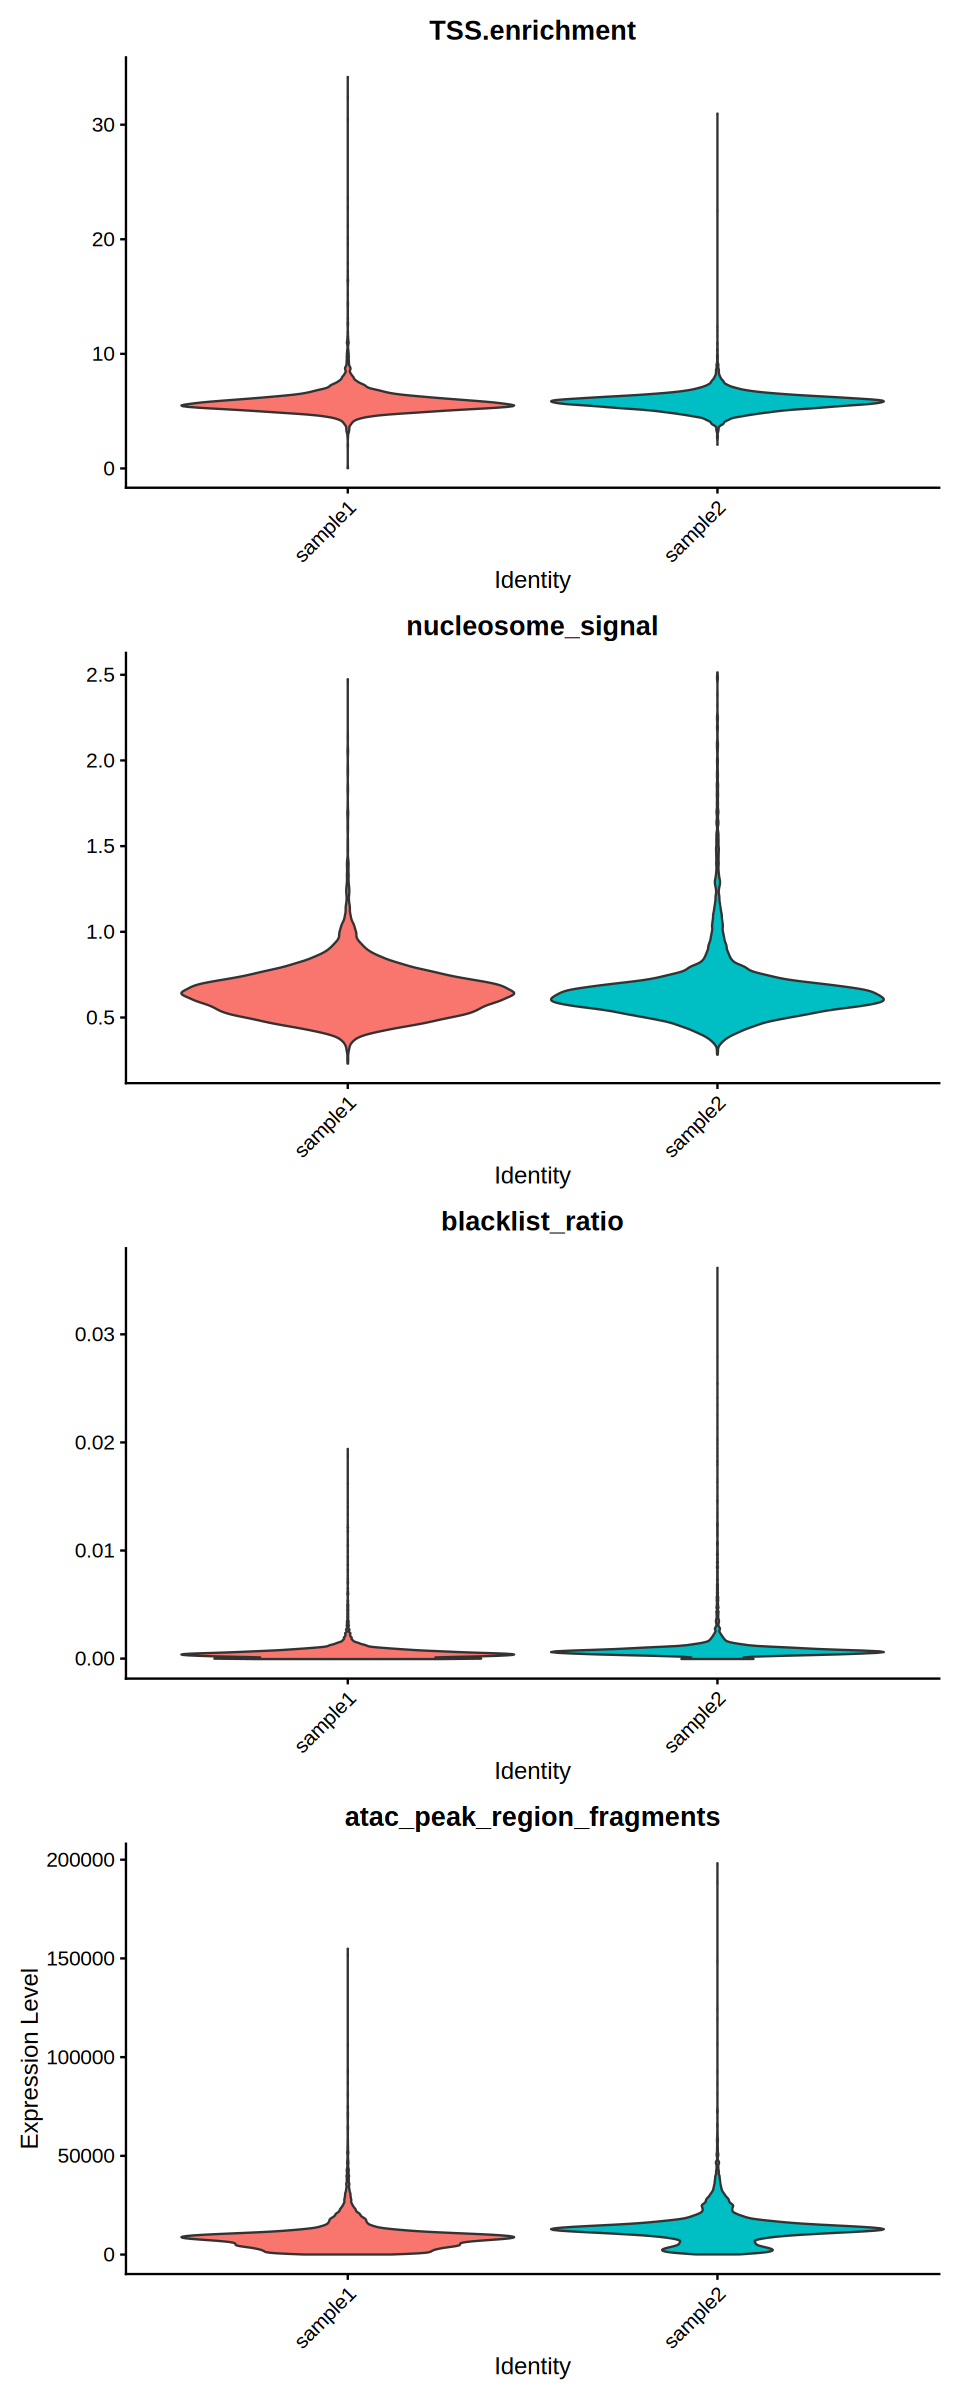

In [37]:
VlnPlot(
  object = data,
  features = c('TSS.enrichment',  'nucleosome_signal','blacklist_ratio','atac_peak_region_fragments' ),
  group.by='dataset',
  pt.size = 0,
  ncol = 1
)

### Step2-4. Apply quality control filtering to remove low-quality cells

##### After computing the key QC metrics, the next step is to filter out low-quality cells and outliers. These cells often represent technical artifacts or sequencing errors and can negatively impact downstream analysis.


##### Common thresholds include:

- Nucleosome Signal: Remove cells with unusually high nucleosome signals (>4).

- TSS Enrichment: Keep cells with TSS enrichment >2~4.

- Total Fragments in Peaks: Remove cells with very low (<500~1000) or very high (>20000) fragment counts.

- Blacklist Ratio: Remove cells with high fractions of reads in blacklist regions (>0.05).



In [37]:
data

An object of class Seurat 
130381 features across 22703 samples within 1 assay 
Active assay: ATAC (130381 features, 0 variable features)
 2 layers present: counts, data

In [38]:
data <- subset(
  x = data,
  subset =
    blacklist_ratio < 0.01 &
    nucleosome_signal < 4 &
    TSS.enrichment > 4 &
    atac_peak_region_fragments > 500 & 
    atac_peak_region_fragments < 20000
)

In [38]:
data

An object of class Seurat 
130381 features across 22703 samples within 1 assay 
Active assay: ATAC (130381 features, 0 variable features)
 2 layers present: counts, data

In [39]:
saveRDS(data,'PBMC.ATAC.after_basic_qc.rds')

## Step3. Doublet detection

In single-cell ATAC-seq (scATAC-seq), accurate identification of doublets—droplets that contain two or more cells instead of one—is critical for ensuring the validity of downstream analyses such as clustering, trajectory inference, and differential accessibility testing.

Compared to scRNA-seq, scATAC-seq data is significantly sparser due to the binary nature of chromatin accessibility and limited per-cell coverage. This increased sparsity makes it challenging to detect doublets using RNA-based methods directly. Therefore, specialized approaches tailored for scATAC-seq are necessary.

Below, we describe two orthogonal methods for doublet scoring, both implemented in the R package
- Simulated Doublet Scoring
- Coverage-Based Doublet Scoring


### Step3-1. Simulated Doublet Scoring

- This method relies on creating artificial doublets by combining chromatin accessibility profiles of random pairs of cells. To combat sparsity:
- The resulting synthetic doublets are compared to real cells using distance-based metrics to compute doublet scores.

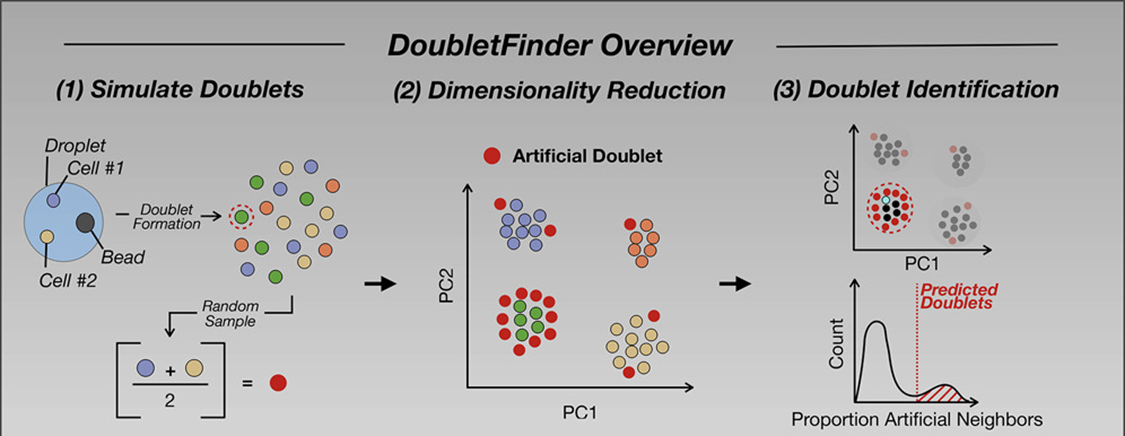

##### Run scDblFinder

In [3]:
sce <- scDblFinder(
    SingleCellExperiment(list(counts=data@assays\$ATAC\$counts)),
    clusters=TRUE, aggregateFeatures=TRUE, nfeatures=25, processing="normFeatures"
)

res_scDbl <- colData(sce)
res_scDbl$scDblFinder.p <- 1 - res_scDbl[,"scDblFinder.score"]
row.names(res_scDbl) <- colnames(data@assays\$ATAC\$counts)

Warning message in .checkSCE(sce, coerce = is.null(samples)):
“Some cells in `sce` have an extremely low read counts; note that these could trigger errors and might best be filtered out”
Aggregating features...

Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 6519050)”
Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 6519050)”
Clustering cells...

Warning message in (function (A, nv = 5, nu = nv, maxit = 1000, work = nv + 7, reorth = TRUE, :
“You're computing too large a percentage of total singular values, use a standard svd instead.”
11 clusters

Creating ~18163 artificial doublets...

Dimensional reduction

Evaluating kNN...

Training model...

iter=0, 2398 cells excluded from training.

Warning message in check.deprecation(deprecated_cv_params, match.call(), ...):
“Passed invalid function arguments: max_depth, eval_metric, tree_method, subsample, nthread, eta. These should be passed as a list to argument 'params'. Conversion from argument to 'params

In [4]:
head(res_scDbl)

DataFrame with 6 rows and 9 columns
                           scDblFinder.cluster scDblFinder.class
                                     <numeric>          <factor>
sample1_AAACAGCCAAAGCCTC-1                   1           singlet
sample1_AAACAGCCAGAATGAC-1                   7           doublet
sample1_AAACAGCCAGCTACGT-1                   4           singlet
sample1_AAACAGCCAGGCCTTG-1                   7           singlet
sample1_AAACAGCCATAAGGAC-1                   9           singlet
sample1_AAACAGCCATAATGTC-1                   1           singlet
                           scDblFinder.score scDblFinder.weighted
                                   <numeric>            <numeric>
sample1_AAACAGCCAAAGCCTC-1        0.00943396           0.02198835
sample1_AAACAGCCAGAATGAC-1        0.47836596           0.12442606
sample1_AAACAGCCAGCTACGT-1        0.01596467           0.00426092
sample1_AAACAGCCAGGCCTTG-1        0.31960412           0.25775162
sample1_AAACAGCCATAAGGAC-1        0.01415094    

### Step3-2. Coverage-Based Doublet Scoring

- Based on the diploid nature of the genome: a maximum of two reads should map to the same genomic position per cell.

- AMULET identifies positions with >2 overlapping fragments, which is a strong indicator of a doublet.


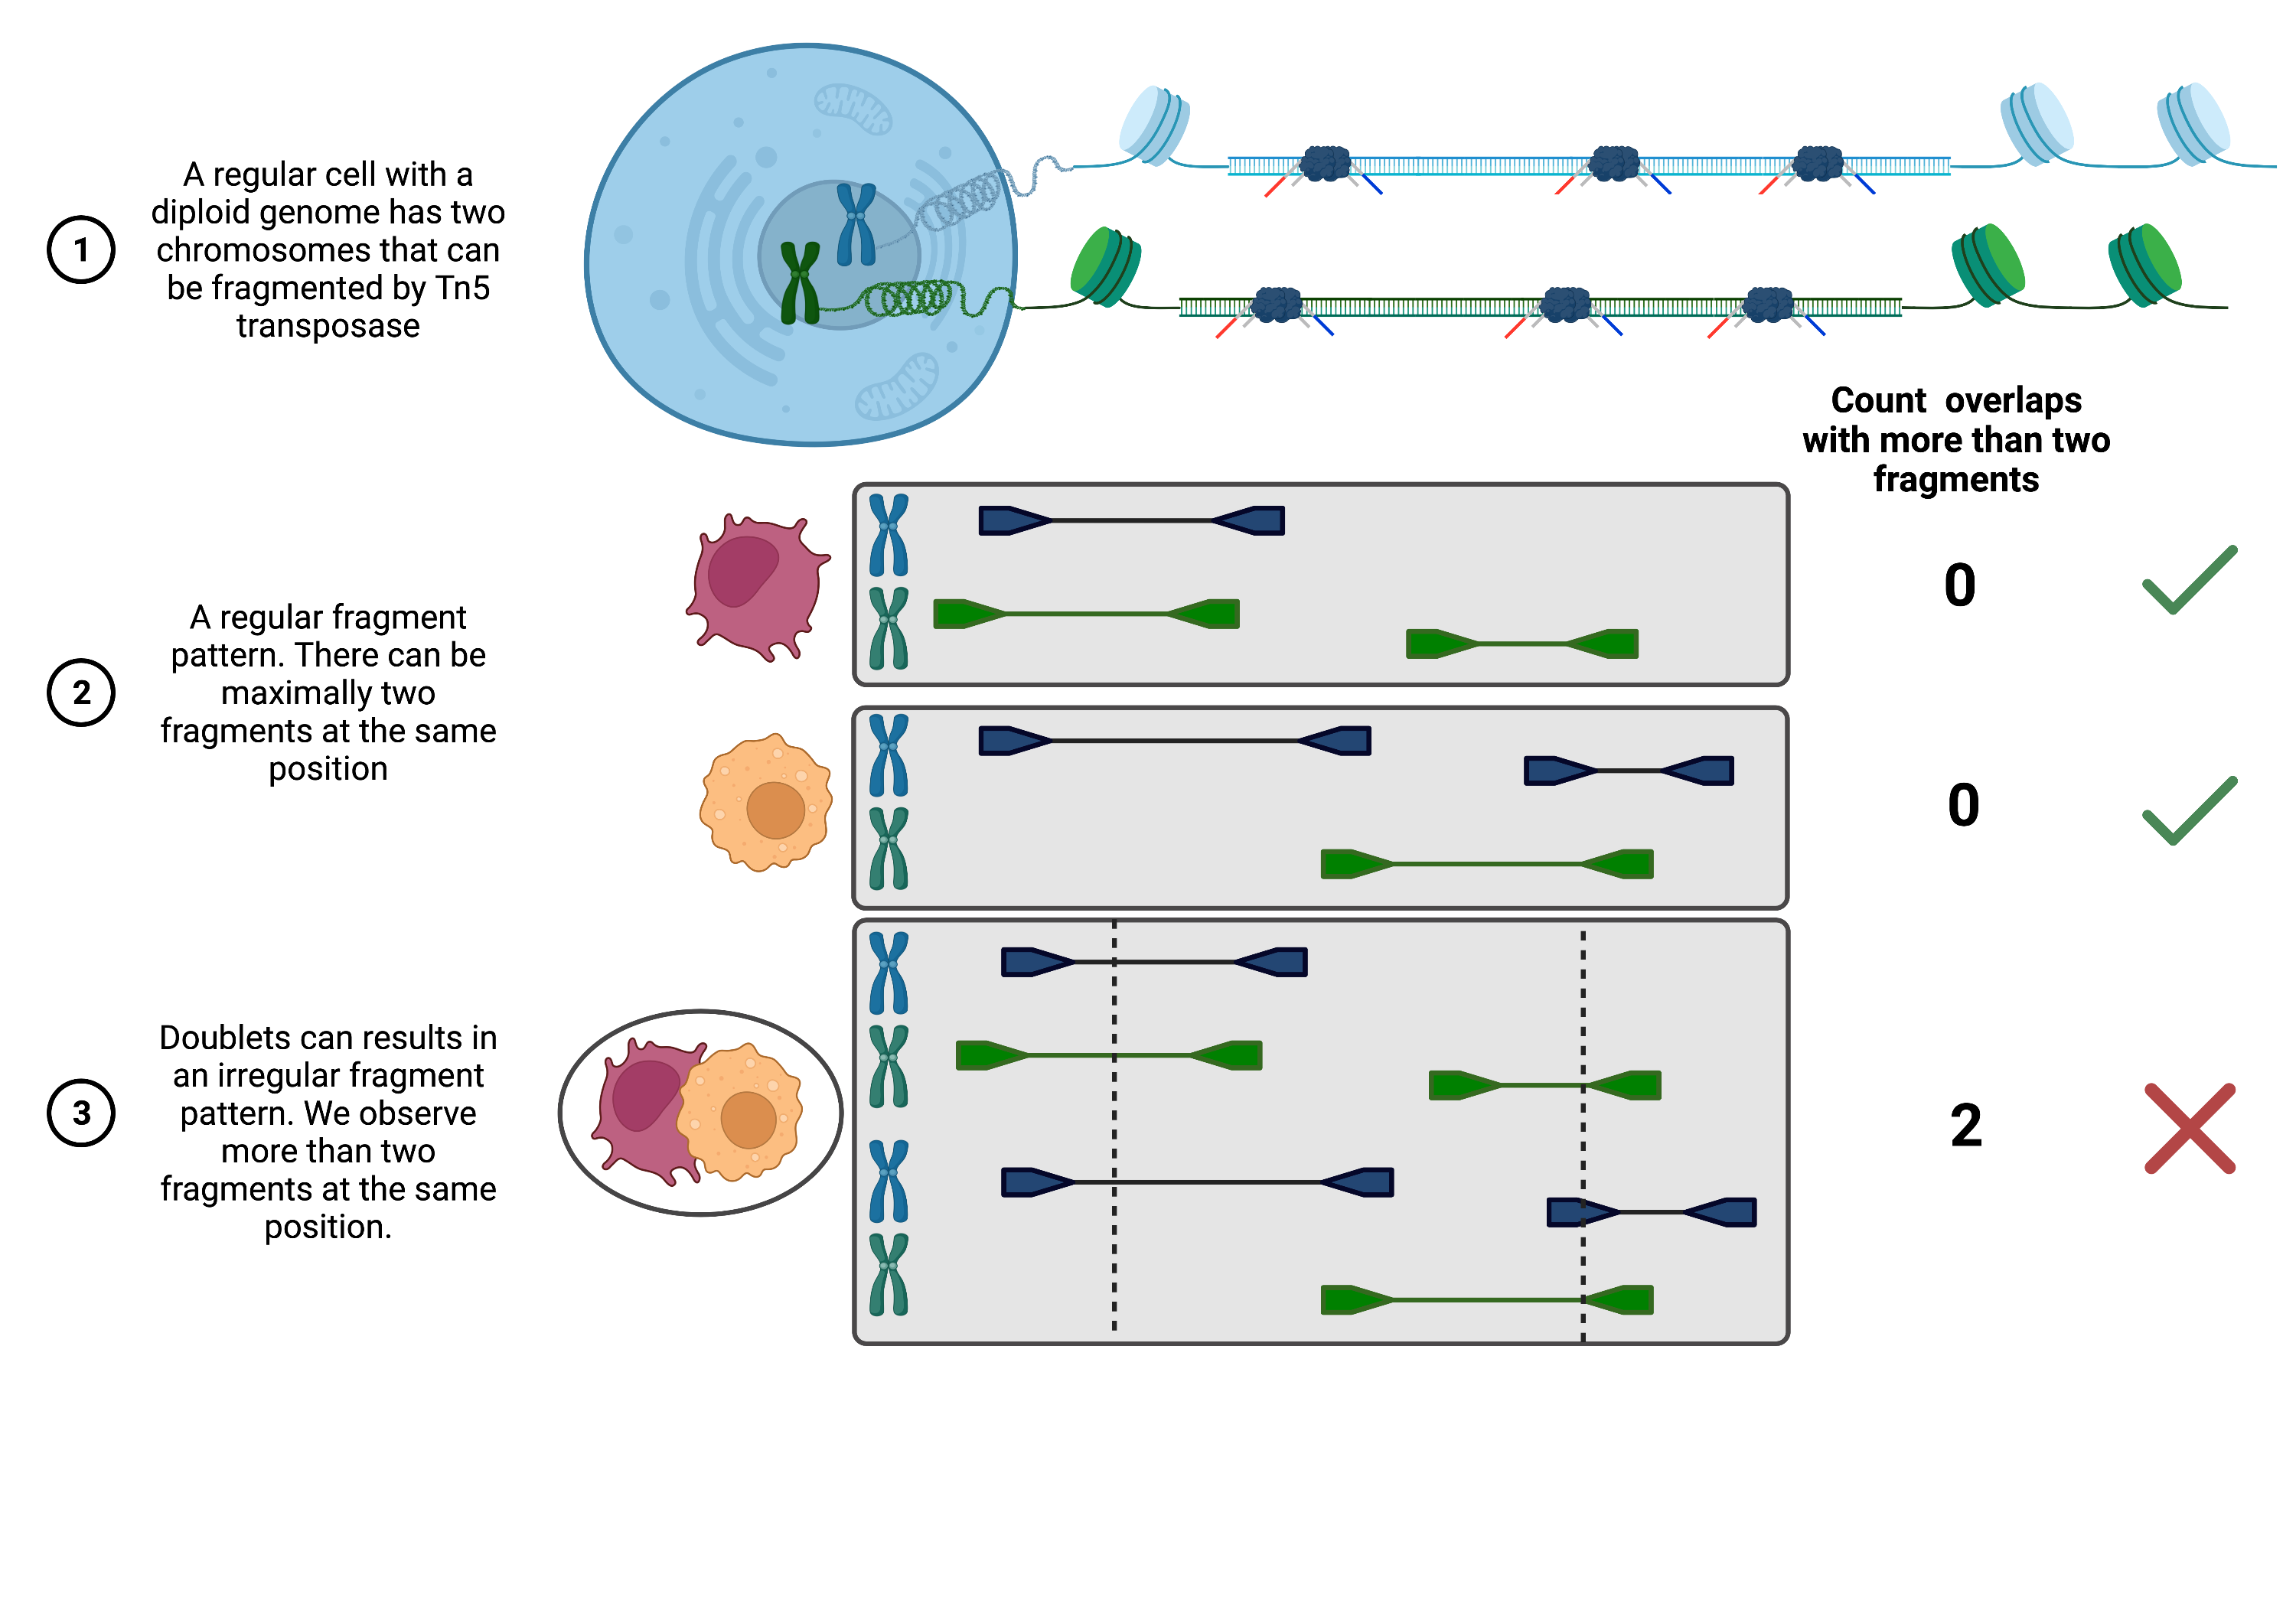

https://www.sc-best-practices.org/chromatin_accessibility/quality_control.html

##### Set the blacklists include X/Y/MT

In [44]:
blRegions <- blacklist_hg38_unified
otherChroms <- GRanges(c("chrM", "chrX", "chrY", "MT"), IRanges(1L, width=10^8))

toExclude <- suppressWarnings(c(blRegions, otherChroms))


##### Run AMULET separately on each dataset to detect doublets
##### Extract barcodes for each sample separately

In [4]:
# Extract barcodes from the merged dataset (Sample 1 + Sample 2)
barcode_list = colnames(data@assays\$ATAC\$counts)

#Extract barcodes corresponding to Sample 1
sample1_barcode_list = barcode_list[grep('sample1', barcode_list)]

#Extract barcodes corresponding to Sample 2
sample2_barcode_list = barcode_list[grep('sample2', barcode_list)]

# Remove sample index prefix from barcodes
sample1_barcode_list = sub('sample1_','', sample1_barcode_list)
sample2_barcode_list = sub('sample2_','', sample2_barcode_list)


##### Specify the fragment file path for each dataset.

In [46]:
sample1_frag_file='pbmc_unsorted_10k_atac_fragments.tsv.gz'
sample2_frag_file='10k_PBMC_Multiome_nextgem_Chromium_Controller_atac_fragments.tsv.gz'


##### Run AMULET separately on each dataset.
<span style="color:red">###### Note: This step is time-consuming (may take several hours), so we will not execute it during this session.

In [ ]:
## sample1
sample1_res_amulet <- amulet(sample1_frag_file, barcodes=sample1_barcode_list, regionsToExclude=toExclude)
colnames(sample1_res_amulet) <- paste0("amulet.", colnames(sample1_res_amulet))
colnames(sample1_res_amulet)[5] <- "amulet.p"
colnames(sample1_res_amulet)[6] <- "amulet.q"
saveRDS(sample1_res_amulet,'PMBC.ATAC.sample1_res_amulet.rds')

## sample2
sample2_res_amulet <- amulet(sample2_frag_file, barcodes=sample2_barcode_list, regionsToExclude=toExclude)
colnames(sample2_res_amulet) <- paste0("amulet.", colnames(sample2_res_amulet))
colnames(sample2_res_amulet)[5] <- "amulet.p"
colnames(sample2_res_amulet)[6] <- "amulet.q"
saveRDS(sample2_res_amulet,'PBMC.ATAC.sample2_res_amulet.rds')


12:32:22 - Reading Tabix-indexed fragment file and computing overlaps



chr1, 

Warning message in FileForFormat(buffer, format):
"Use BiocIO::FileForFormat"


chr10, 

Warning message in FileForFormat(buffer, format):
"Use BiocIO::FileForFormat"


chr11, 

Warning message in FileForFormat(buffer, format):
"Use BiocIO::FileForFormat"


chr12, 

Warning message in FileForFormat(buffer, format):
"Use BiocIO::FileForFormat"


chr13, 

Warning message in FileForFormat(buffer, format):
"Use BiocIO::FileForFormat"


chr14, 

Warning message in FileForFormat(buffer, format):
"Use BiocIO::FileForFormat"


chr15, 

Warning message in FileForFormat(buffer, format):
"Use BiocIO::FileForFormat"


chr16, 

Warning message in FileForFormat(buffer, format):
"Use BiocIO::FileForFormat"


chr17, 

Warning message in FileForFormat(buffer, format):
"Use BiocIO::FileForFormat"


chr18, 

Warning message in FileForFormat(buffer, format):
"Use BiocIO::FileForFormat"


chr19, 

Warning message in FileForFormat(buffer, format):
"Use BiocIO::FileForFormat"


chr2, 

Warning message in FileForFormat(buffer, format):
"Use BiocIO::FileForFormat"


chr20, 

Warning message in FileForFormat(buffer, format):
"Use BiocIO::FileForFormat"


chr21, 

Warning message in FileForFormat(buffer, format):
"Use BiocIO::FileForFormat"


chr22, 

Warning message in FileForFormat(buffer, format):
"Use BiocIO::FileForFormat"


chr3, 

Warning message in FileForFormat(buffer, format):
"Use BiocIO::FileForFormat"


chr4, 

Warning message in FileForFormat(buffer, format):
"Use BiocIO::FileForFormat"


##### Use the pre-generated dataset to skip time-consuming preprocessing steps.

In [5]:
sample1_res_amulet = readRDS('PBMC.ATAC.sample1_res_amulet.rds')
sample2_res_amulet = readRDS('PBMC.ATAC.sample2_res_amulet.rds')


##### Merge the doublet metric results from each sample into a single combined dataset

In [6]:
# Add sample-specific index prefixes to the barcodes of each sample.
rownames(sample1_res_amulet)= paste0('sample1_',rownames(sample1_res_amulet))
rownames(sample2_res_amulet)= paste0('sample2_',rownames(sample2_res_amulet))

# Merge the results into a single combined dataset.
res_amulet = rbind(sample1_res_amulet,sample2_res_amulet)


In [7]:
head(res_amulet)

,amulet.nFrags,amulet.uniqFrags,amulet.nAbove2,amulet.total.nAbove2,amulet.p,amulet.q
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
sample1_AAACAGCCAAAGCCTC-1,383,383,0,0,9.991736e-01,9.991736e-01
sample1_AAACAGCCAGAATGAC-1,14101,14101,6,19,5.648456e-01,9.991736e-01
sample1_AAACAGCCAGCTACGT-1,3129,3129,0,0,9.991736e-01,9.991736e-01
sample1_AAACAGCCAGGCCTTG-1,9949,9949,0,1,9.991736e-01,9.991736e-01
sample1_AAACAGCCATAAGGAC-1,1216,1216,0,0,9.991736e-01,9.991736e-01
sample1_AAACAGCCATAATGTC-1,25167,25167,54,333,4.853555e-30,2.429204e-28


### Step3-3. Integrate doublet-related metrics into the object and apply doublet filtering.

##### Merge doublet detection results from two different methods and aggregate the p-values

In [19]:
# Merge doublet detection results from two different methods 
res <- merge(res_scDbl, res_amulet, by="row.names", all.x=T)
res = as.data.frame(res)

## Aggregate the p-values obtained from two methods
res$combined.p <- apply(res[,c("scDblFinder.p", "amulet.p")], 1, FUN=function(x){
  x[x<0.001] <- 0.001
  suppressWarnings(aggregation::fisher(x))
})

# save stats to output file
colnames(res)[1] <- "barcode"
write.table(res, file='doublet_metric.tsv', quote=F, sep="\t", row.names=F)


In [20]:
head(res)

,barcode,scDblFinder.cluster,scDblFinder.class,scDblFinder.score,scDblFinder.weighted,scDblFinder.difficulty,scDblFinder.cxds_score,scDblFinder.mostLikelyOrigin,scDblFinder.originAmbiguous,scDblFinder.p,amulet.nFrags,amulet.uniqFrags,amulet.nAbove2,amulet.total.nAbove2,amulet.p,amulet.q,combined.p
,<I<chr>>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,sample1_AAACAGCCAAAGCCTC-1,1,singlet,0.009433962,0.021988349,0.3211463,0.000000e+00,3+7,TRUE,0.9905660,383,383,0,0,9.991736e-01,9.991736e-01,0.999947262
2,sample1_AAACAGCCAGAATGAC-1,7,doublet,0.478365956,0.124426061,0.3637487,8.152225e-01,1+7,FALSE,0.5216340,14101,14101,6,19,5.648456e-01,9.991736e-01,0.654693692
3,sample1_AAACAGCCAGCTACGT-1,4,singlet,0.015964665,0.004260924,0.3144388,2.249537e-02,7+8,FALSE,0.9840353,3129,3129,0,0,9.991736e-01,9.991736e-01,0.999858457
4,sample1_AAACAGCCAGGCCTTG-1,7,singlet,0.319604117,0.257751624,0.3637487,3.844913e-01,1+7,FALSE,0.6803959,9949,9949,0,1,9.991736e-01,9.991736e-01,0.942186287
5,sample1_AAACAGCCATAAGGAC-1,9,singlet,0.014150943,0.023508935,0.3211463,2.505404e-42,3+7,FALSE,0.9858491,1216,1216,0,0,9.991736e-01,9.991736e-01,0.999887451
6,sample1_AAACAGCCATAATGTC-1,1,singlet,0.344224725,0.165973059,0.3211463,5.092042e-01,3+7,TRUE,0.6557753,25167,25167,54,333,4.853555e-30,2.429204e-28,0.005462406


##### Integrate doublet-related metircs into the signac object

In [21]:
data <- AddMetaData(object = data, metadata = res)

Warning message:
“`FilterObjects()` was deprecated in SeuratObject 5.0.0.
ℹ Please use `.FilterObjects()` instead.
ℹ The deprecated feature was likely used in the SeuratObject package.
  Please report the issue at <https://github.com/satijalab/seurat-object/issues>.”


##### Apply doublet filtreing

In [23]:
data <- subset(
  x = data,
  subset =
    combined.p > 0.25 

)

##### Save the result

In [24]:
saveRDS(data,'PBMC.ATAC.after_qc.rds')